In [1]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from random import shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data from a file and append it to the rawData
def parseReview(reviewLine):
    # Should return a triple of an integer, a string containing the review, and a string indicating the label
    return (reviewLine[0], reviewLine[2], reviewLine[3], reviewLine[4], reviewLine[5], reviewLine[6], reviewLine[7], reviewLine[8], 'fake' if reviewLine[1] == '__label1__' else 'real')

def loadData(path, Text=None):
    with open(path, encoding='utf8') as f:
        reader = csv.reader(f, delimiter='\t')
        next(reader)
        for line in reader:
            (DOC_ID, RATING, VERIFIED_PURCHASE, PRODUCT_CATEGORY, PRODUCT_ID, PRODUCT_TITLE, REVIEW_TITLE, REVIEW_TEXT, LABEL) = parseReview(line)
            rawData.append((DOC_ID, RATING, VERIFIED_PURCHASE, PRODUCT_CATEGORY, PRODUCT_ID, PRODUCT_TITLE, REVIEW_TITLE, REVIEW_TEXT, LABEL))

In [3]:

rawData = []          # the filtered data from the dataset file (should be 21000 samples)

# references to the data files
reviewPath = 'amazon_reviews.txt'

## Do the actual stuff
# We parse the dataset and put it in a raw data list
print ("Preparing the dataset...")
loadData(reviewPath)

Preparing the dataset...


In [4]:
columns = ["DOC_ID", "RATING", "VERIFIED_PURCHASE", "PRODUCT_CATEGORY", "PRODUCT_ID", "PRODUCT_TITLE", "REVIEW_TITLE", "REVIEW_TEXT", "LABEL"]

In [7]:
data = pd.DataFrame.from_records(rawData, columns=columns)

In [8]:
data.head()

,DOC_ID,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,LABEL
0,1,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",fake
1,2,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,fake
2,3,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,fake
3,4,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...,fake
4,5,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...,fake


In [9]:
data.size

189000

In [10]:
data.shape

(21000, 9)

In [11]:
data.isnull().sum()

DOC_ID               0
RATING               0
VERIFIED_PURCHASE    0
PRODUCT_CATEGORY     0
PRODUCT_ID           0
PRODUCT_TITLE        0
REVIEW_TITLE         0
REVIEW_TEXT          0
LABEL                0
dtype: int64

In [12]:
data.groupby(data["LABEL"]).PRODUCT_CATEGORY.value_counts()

LABEL  PRODUCT_CATEGORY      
fake   Apparel                   350
       Automotive                350
       Baby                      350
       Beauty                    350
       Books                     350
       Camera                    350
       Electronics               350
       Furniture                 350
       Grocery                   350
       Health & Personal Care    350
       Home                      350
       Home Entertainment        350
       Home Improvement          350
       Jewelry                   350
       Kitchen                   350
       Lawn and Garden           350
       Luggage                   350
       Musical Instruments       350
       Office Products           350
       Outdoors                  350
       PC                        350
       Pet Products              350
       Shoes                     350
       Sports                    350
       Tools                     350
       Toys                      350
       V

In [13]:
data.groupby(data["LABEL"]).RATING.value_counts()

LABEL  RATING
fake   5         6059
       4         1999
       3          926
       1          889
       2          627
real   5         6151
       4         1974
       3          942
       1          868
       2          565
Name: RATING, dtype: int64

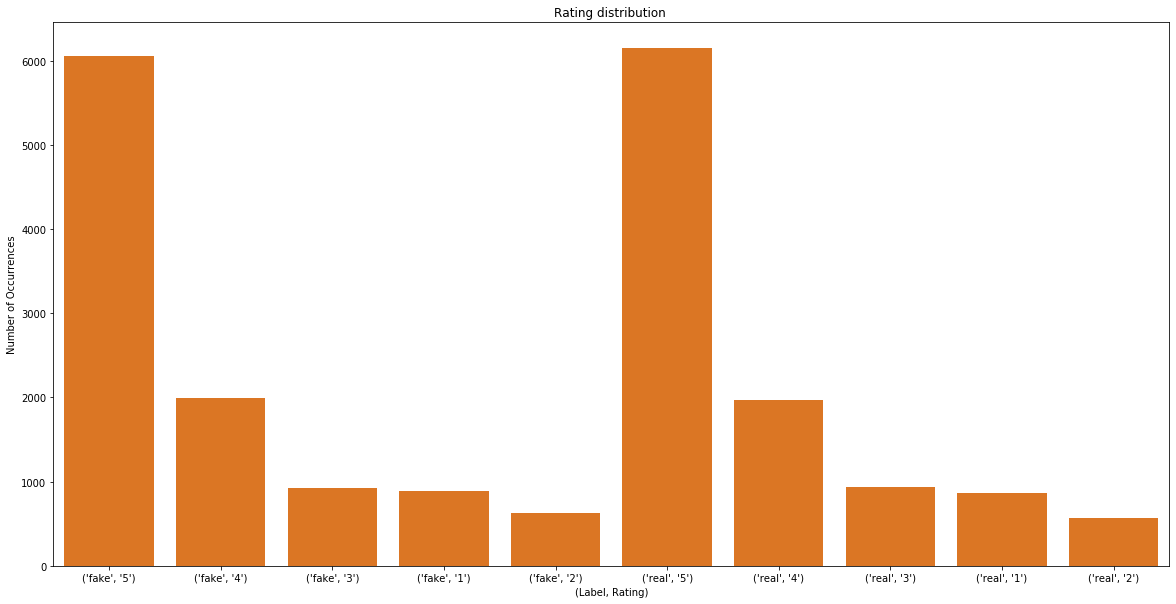

In [16]:
rating_dist = data.groupby(data["LABEL"]).RATING.value_counts()
plt.figure(figsize=(20,10))
sns.barplot(rating_dist.index, rating_dist.values, color=sns.xkcd_rgb["orange"])
plt.ylabel('Number of Occurrences')
plt.xlabel('(Label, Rating)')
plt.title('Rating distribution ')
plt.xticks(rotation='horizontal')
plt.show()

In [17]:
data.groupby("VERIFIED_PURCHASE").LABEL.value_counts()

VERIFIED_PURCHASE  LABEL
N                  fake     7623
                   real     1679
Y                  real     8821
                   fake     2877
Name: LABEL, dtype: int64

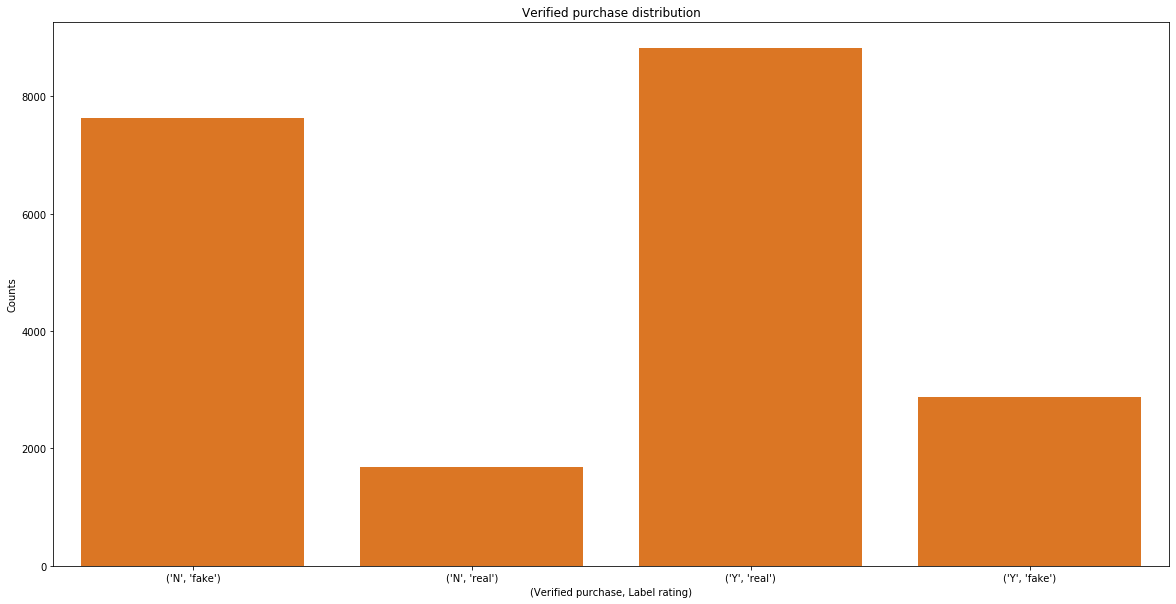

In [18]:
verified_purchase_dist = data.groupby(data["VERIFIED_PURCHASE"]).LABEL.value_counts()
plt.figure(figsize=(20,10))
sns.barplot(verified_purchase_dist.index, verified_purchase_dist.values, color=sns.xkcd_rgb["orange"])
plt.ylabel('Counts')
plt.xlabel('(Verified purchase, Label rating)')
plt.title('Verified purchase distribution')
plt.xticks(rotation='horizontal')
plt.show()

In [19]:
data["REVIEW_LEN"] = data["REVIEW_TEXT"].apply(len)
tot = sum(data["REVIEW_LEN"].values)
data.groupby(["LABEL"]).REVIEW_LEN.agg(lambda x: sum(x)/tot)

LABEL
fake    0.425097
real    0.574903
Name: REVIEW_LEN, dtype: float64

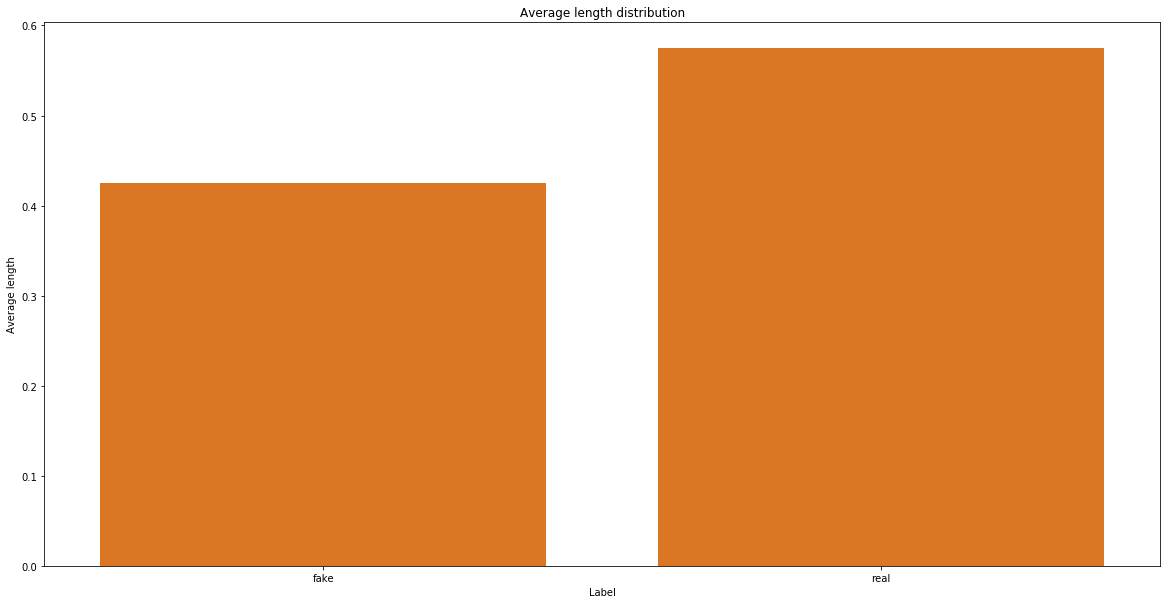

In [21]:
avg_len_distribution = data.groupby(["LABEL"]).REVIEW_LEN.agg(lambda x: sum(x)/tot)
plt.figure(figsize=(20,10))
sns.barplot(avg_len_distribution.index, avg_len_distribution.values, color=sns.xkcd_rgb["orange"])
plt.ylabel('Average length')
plt.xlabel('Label')
plt.title('Average length distribution')
plt.xticks(rotation='horizontal')
plt.show()

In [22]:
from textstat.textstat import textstat
data["FK_Score"] = data["REVIEW_TEXT"].apply(textstat.flesch_kincaid_grade)

In [23]:
data.groupby(["LABEL"]).FK_Score.agg(lambda x: sum(x)/len(x))

LABEL
fake     8.007886
real    13.803848
Name: FK_Score, dtype: float64

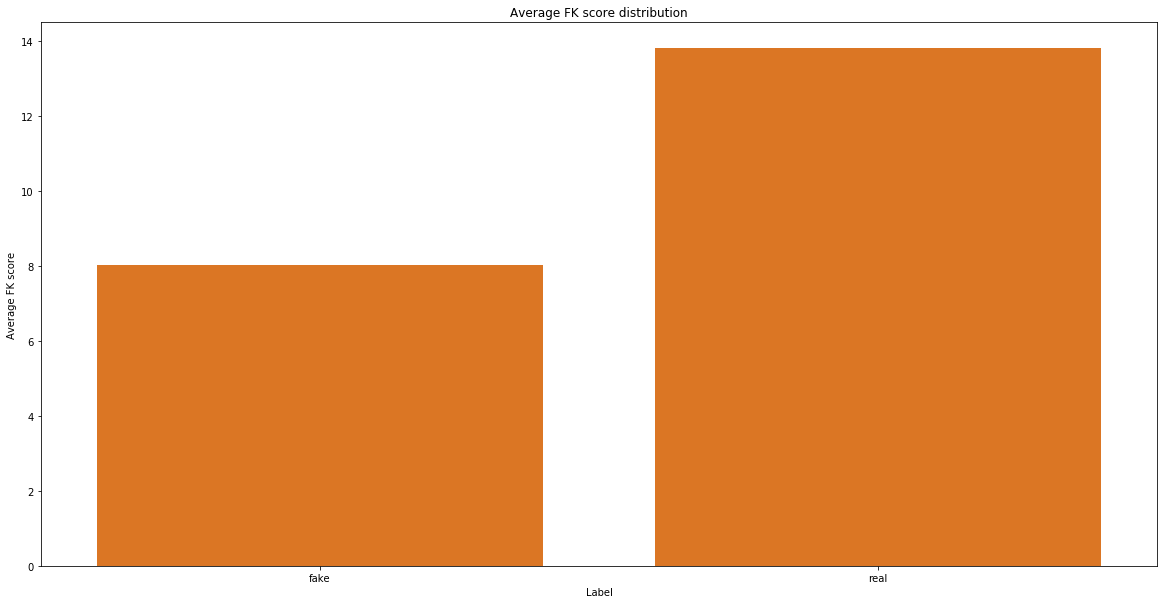

In [24]:
avg_FK_score_distribution = data.groupby(["LABEL"]).FK_Score.agg(lambda x: sum(x)/len(x))
plt.figure(figsize=(20,10))
sns.barplot(avg_FK_score_distribution.index, avg_FK_score_distribution.values, color=sns.xkcd_rgb["orange"])
plt.ylabel('Average FK score')
plt.xlabel('Label')
plt.title('Average FK score distribution')
plt.xticks(rotation='horizontal')
plt.show()

In [25]:
import nltk
stop_words = nltk.corpus.stopwords.words('english')
def stopCount(x):
    sum =0
    for char in x.split():
        sum+= char in stop_words
    return sum
data['stop_words_count'] = data['REVIEW_TEXT'].apply(stopCount)

In [26]:
data.groupby(["LABEL"]).stop_words_count.agg(lambda x: sum(x)/len(x))

LABEL
fake    24.696190
real    32.519048
Name: stop_words_count, dtype: float64

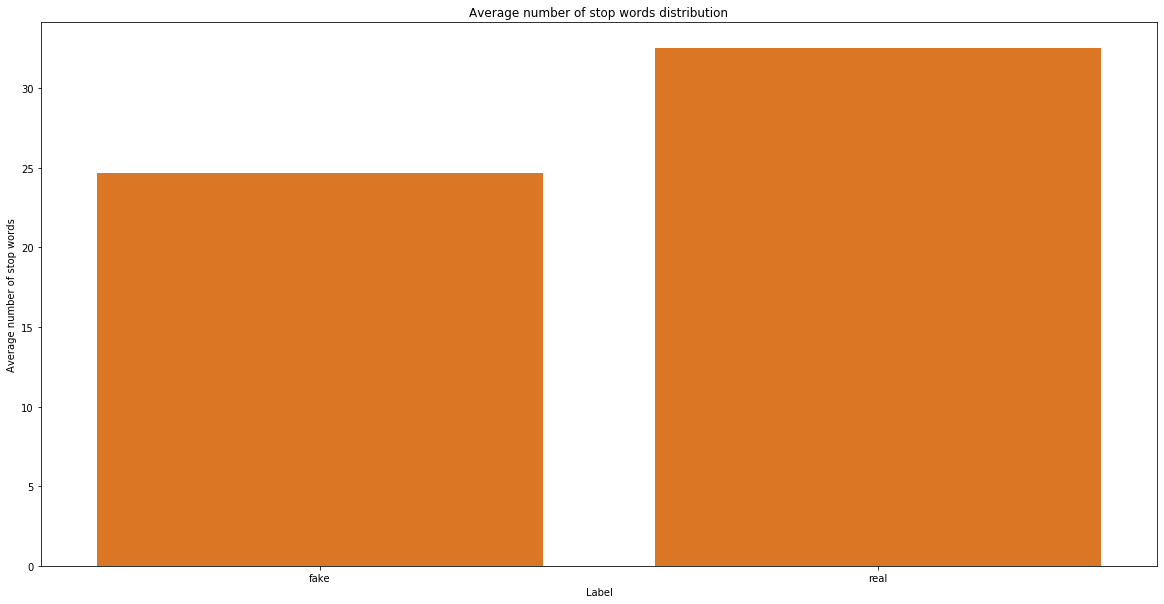

In [27]:
no_of_stop_words_distribution = data.groupby(["LABEL"]).stop_words_count.agg(lambda x: sum(x)/len(x))
plt.figure(figsize=(20,10))
sns.barplot(no_of_stop_words_distribution.index, no_of_stop_words_distribution.values, color=sns.xkcd_rgb["orange"])
plt.ylabel('Average number of stop words')
plt.xlabel('Label')
plt.title('Average number of stop words distribution')
plt.xticks(rotation='horizontal')
plt.show()

In [133]:
# loading reviews
rawData = []          # the filtered data from the dataset file (should be 21000 samples)
preprocessedData = [] # the preprocessed reviews (just to see how your preprocessing is doing)
trainData = []        # the training data as a percentage of the total dataset (currently 80%, or 16800 samples)
testData = []         # the test data as a percentage of the total dataset (currently 20%, or 4200 samples)

# the output classes
fakeLabel = 'fake'
realLabel = 'real'

# references to the data files
reviewPath = 'amazon_reviews.txt'

## Do the actual stuff
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Preparing the dataset...",sep='\n')
loadData(reviewPath) 

trainData = []        # the training data as a percentage of the total dataset (currently 80%, or 16800 samples)
testData = []         # the test data as a percentage of the total dataset (currently 20%, or 4200 samples)
featureDict = {}      # A global dictionary of features

print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Preparing training and test data...",sep='\n')
splitData(0.8)

print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Training Samples: ", len(trainData), "Features: ", len(featureDict), sep='\n')

print("Results after cross-validations: ", crossValidate(trainData, 10))

Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 21000 rawData, 0 trainData, 0 testData
Preparing training and test data...
Now 21000 rawData, 16800 trainData, 4200 testData
Training Samples: 
16800
Features: 
1648791
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Results after cross-validations:  [0.82272475 0.82163739 0.821387   0.82160714]


In [134]:
print(len(trainData))
classifier = trainClassifier(trainData)
predictions = predictLabels(testData, classifier)
true_labels = list(map(lambda d: d[1], testData))
a = accuracy_score(true_labels, predictions)
p, r, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
print("Precision: ", p)
print("Recall: ", a)
print("f1-score: ", f1)
print("accuracy: ", a)

16800
Training Classifier...
Precision:  0.8225787208404047
Recall:  0.8188095238095238
f1-score:  0.8182786894892682
accuracy:  0.8188095238095238
